## FEATURES

* dataset mas grande (2000 datos)

In [1]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/FINAL_DATASET_CLEAN.xlsx'

In [4]:

import pandas as pd

data = pd.read_excel(folder)

In [5]:
data.head()

,Unnamed: 0,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Calefacción,Cocina,...,Plantas,Parrillero,Acepta Mascotas,Patio,Dormitorio,barrio,municipio,precio_por_m2_construido,precio_por_m2_terreno,precio_por_m2
0,0,https://www.casasymas.com.uy/propiedad/186603-...,675000,4.0,NaN,242,268,2,0,NaN,...,3.0,1,NaN,0,4.0,parque-batlle,CH,2789.256198,2518.656716,NaN
1,2,https://www.casasymas.com.uy/propiedad/212637-...,148000,2.0,131.0,98,131,1,0,Cocina Integrada,...,NaN,0,Acepta Mascotas,0,2.0,belvedere,A,1510.204082,1129.770992,1129.770992
2,3,https://www.casasymas.com.uy/propiedad/225135-...,625000,3.0,408.0,234,174,1,0,Cocina Definida,...,NaN,0,Acepta Mascotas,0,4.0,carrasco,E,2670.940171,3591.954023,1531.862745
3,4,https://www.casasymas.com.uy/propiedad/225720-...,580000,2.0,285.0,156,201,0,0,NaN,...,NaN,0,NaN,0,3.0,carrasco,E,3717.948718,2885.572139,2035.087719
4,6,https://www.casasymas.com.uy/propiedad/186448-...,670000,4.0,NaN,249,321,2,0,NaN,...,2.0,0,Acepta Mascotas,0,4.0,pocitos,CH,2690.763052,2087.227414,NaN


## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [6]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # División : train vs test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Preprocesador combinado
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO en training
    preprocess.fit(X_train)

    # Transformar datos
    X_train_prep = preprocess.transform(X_train)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_test_prep,
        y_train, y_test,
        preprocess,
        X_test.index
    )


In [24]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [25]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):

    # Parámetros por defecto optimizados para MAE

    if params is None:
        params = {
            "objective": "l1",
            "metric": "mae",
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model

In [26]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.01,
        objective="reg:absoluteerror",
        random_state=42,
        tree_method="hist"
    )

    model.fit(X_train, y_train)
    return model


In [27]:
from sklearn.model_selection import GridSearchCV

def train_xgboost_gridsearch(X_train, y_train, cv_folds=5, n_jobs=-1):

    param_grid = {
        "n_estimators": [600, 900, 1200],
        "learning_rate": [0.01, 0.03, 0.05],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [1.0, 2.0, 5.0],
        "reg_alpha": [0, 0.01, 0.1]
    }

    xgb = XGBRegressor(
        objective="reg:absoluteerror",
        tree_method="hist",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",  # optimizar MAE
        cv=cv_folds,
        verbose=1,
        n_jobs=n_jobs
    )

    grid.fit(X_train, y_train)

    print("\n======== MEJORES PARÁMETROS XGBOOST ========")
    print(grid.best_params_)
    print("\nMejor MAE (en log-space):", -grid.best_score_)
    print("=============================================\n")

    # Modelo final con los mejores hiperparámetros
    best_model = grid.best_estimator_

    return best_model


In [28]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf

In [29]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [30]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


In [31]:
def evaluation_table(model, X_test_prep, y_test, df_original, extra_cols=None):

    # Predicción en log
    y_pred_log = model.predict(X_test_prep)

    # Convertir a precio real
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # Tabla base
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
    })

    results["Error Absoluto"] = np.abs(results["Precio Real"] - results["Precio Predicho"])
    results["Error %"] = 100 * results["Error Absoluto"] / results["Precio Real"]

    # Agregar columnas originales
    if extra_cols:
        df_extra = df_original.reset_index(drop=True)[extra_cols]
        results = pd.concat([results, df_extra], axis=1)

    return results.sort_values(by="Error %", ascending=False).reset_index(drop=True)


## Target y Features

In [32]:
features = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage"]

target = "precio"

## Train Test Splits

In [43]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=data,
        target=target,
        num_cols=features,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


In [44]:
data_ch = data[data["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        random_state=42
    )


In [45]:
data_e = data[data["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_test_prep_e,
    y_train_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,
        target=target,
        num_cols=features,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


## Modelos

Entrenamos los siguientes modelos:

* XGB
* XGB CH
* XGB E
* LGBM
* LGBM CH
* LGBM E
* LR
* LR CH
* LR E
* RF
* RF CH
* RF E

Nombres de modelos:

* `xgb`
* `model_lgbm`
* `lgbm_ch`
* `lgbm_e`
* `model_lr`
* `model_lr_ch`
* `model_lr_e`
* `rf_all_municipios`
* `rf_municipio_ch`
* `rf_municipio_e`

## `xgb`

In [46]:
xgb = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)


In [47]:
mse_xgb, r2_xgb, mae_xgb, medae_xgb, mape_xgb, mdape_xgb = evaluate_model(
    xgb,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Median Absolute Error (XGB): {medae_xgb}")
print(f"MAPE (XGB): {mape_xgb}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb}")


Mean Squared Error (MSE): 24943166570.021557
R² Score: 0.7739572894630399
Mean Absolute Error (MAE): 84803.67721307834
Median Absolute Error (XGB): 46354.37499999988
MAPE (XGB): 20.82613475428988
Median Absolute Percentage Error (XGB): 15.26826136363634


## `xgb_ch`

In [48]:
xgb_ch = train_xgboost(
    X_train_prep_ch,
    y_train_ch
)

print("XGBoost  entrenado:", xgb_ch)

XGBoost  entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [49]:
mse_xgb_ch, r2_xgb_ch, mae_xgb_ch, medae_xgb_ch, mape_xgb_ch, mdape_xgb_ch = evaluate_model(
    xgb_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (MSE): {mse_xgb_ch}")
print(f"R² Score: {r2_xgb_ch}")
print(f"Mean Absolute Error (MAE): {mae_xgb_ch}")
print(f"Median Absolute Error (XGB): {medae_xgb_ch}")
print(f"MAPE (XGB): {mape_xgb_ch}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_ch}")


Mean Squared Error (MSE): 46623235983.95367
R² Score: 0.5481714944155234
Mean Absolute Error (MAE): 118814.35503472226
Median Absolute Error (XGB): 46309.03125000007
MAPE (XGB): 21.86347913985095
Median Absolute Percentage Error (XGB): 19.368447597789075


## `xgb_e`

In [50]:
xgb_e = train_xgboost(
    X_train_prep_e,
    y_train_e
)

print("XGBoost  entrenado:", xgb_e)

XGBoost  entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [51]:
mse_xgb_e, r2_xgb_e, mae_xgb_e, medae_xgb_e, mape_xgb_e, mdape_xgb_e = evaluate_model(
    xgb_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (MSE): {mse_xgb_e}")
print(f"R² Score: {r2_xgb_e}")
print(f"Mean Absolute Error (MAE): {mae_xgb_e}")
print(f"Median Absolute Error (XGB): {medae_xgb_e}")
print(f"MAPE (XGB): {mape_xgb_e}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_e}")


Mean Squared Error (MSE): 31487098042.853607
R² Score: 0.7287395060362194
Mean Absolute Error (MAE): 121146.34857954549
Median Absolute Error (XGB): 83091.2343750002
MAPE (XGB): 21.973254173832895
Median Absolute Percentage Error (XGB): 16.147902891980177


## `model_lgbm` (all municipios)

In [52]:
model_lgbm = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 1124, number of used features: 29
[LightGBM] [Info] Start training from score 12.611538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [53]:
mse_lgbm, r2_lgbm, mae_lgbm, medae_lgbm, mape_lgbm, mdape_lgbm = evaluate_model(
    model_lgbm,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm}")
print(f"R² Score (LGBM): {r2_lgbm}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm}")
print(f"Median Absolute Error (LGBM): {medae_lgbm}")
print(f"MAPE (LGBM): {mape_lgbm}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm}")

Mean Squared Error (LGBM): 26994768107.813046
R² Score (LGBM): 0.7553650401092008
Mean Absolute Error (LGBM): 88392.91624445598
Median Absolute Error (LGBM): 49171.0108834031
MAPE (LGBM): 22.04224383712049
Median Absolute Percentage Error (LGBM): 16.972423612618645


## `lgbm_ch`

In [54]:
# Modelo CH
lgbm_ch = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH  entrenado:", lgbm_ch)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 214, number of used features: 11
[LightGBM] [Info] Start training from score 12.676076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [55]:
mse_lgbm_ch, r2_lgbm_ch, mae_lgbm_ch, medae_lgbm_ch, mape_lgbm_ch, mdape_lgbm_ch = evaluate_model(
    lgbm_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH ): {mse_lgbm_ch}")
print(f"R² Score (LGBM CH ): {r2_lgbm_ch}")
print(f"Mean Absolute Error (LGBM CH ): {mae_lgbm_ch}")
print(f"Median Absolute Error (LGBM CH ): {medae_lgbm_ch}")
print(f"MAPE (LGBM CH ): {mape_lgbm_ch}")
print(f"Median Absolute Percentage Error (LGBM CH ): {mdape_lgbm_ch}")

Mean Squared Error (LGBM CH ): 53259269022.10391
R² Score (LGBM CH ): 0.4838613102904107
Mean Absolute Error (LGBM CH ): 120497.7074749404
Median Absolute Error (LGBM CH ): 52372.7823675836
MAPE (LGBM CH ): 22.17909221846914
Median Absolute Percentage Error (LGBM CH ): 14.158200937156085


## `lgbm_e`

In [56]:
# Modelo E
lgbm_e = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E  entrenado:", lgbm_e)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 438, number of used features: 11
[LightGBM] [Info] Start training from score 13.217091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [57]:
mse_lgbm_e, r2_lgbm_e, mae_lgbm_e, medae_lgbm_e, mape_lgbm_e, mdape_lgbm_e = evaluate_model(
    lgbm_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E ): {mse_lgbm_e}")
print(f"R² Score (LGBM E ): {r2_lgbm_e}")
print(f"Mean Absolute Error (LGBM E ): {mae_lgbm_e}")
print(f"Median Absolute Error (LGBM E ): {medae_lgbm_e}")
print(f"MAPE (LGBM E ): {mape_lgbm_e}")
print(f"Median Absolute Percentage Error (LGBM E ): {mdape_lgbm_e}")


Mean Squared Error (LGBM E ): 34776728120.07747
R² Score (LGBM E ): 0.7003994323180451
Mean Absolute Error (LGBM E ): 134298.40808773163
Median Absolute Error (LGBM E ): 92323.79022012978
MAPE (LGBM E ): 24.311643673797114
Median Absolute Percentage Error (LGBM E ): 18.734972908304876


## `model_lr`

Todos los municipios, features s

In [58]:
model_lr = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr)

Modelo entrenado: LinearRegression()


In [59]:
mse_lr, r2_lr, mae_lr, medae_lr, mape_lr, mdape_lr  = evaluate_model(model_lr, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr}")
print(f"R² Score (Real): {r2_lr}")
print(f"Mean Absolute Error (Real): {mae_lr}")
print(f"Median Absolute Error (Real): {medae_lr}")
print(f"MAPE: {mape_lr}")
print(f"Median Absolute Percentage Error (%): {mdape_lr}")

Mean Squared Error (Real): 23503605844.598743
R² Score (Real): 0.7870030351763454
Mean Absolute Error (Real): 91579.73616380889
Median Absolute Error (Real): 52042.77815810329
MAPE: 23.566545069084114
Median Absolute Percentage Error (%): 19.240592200412678


## `model_lr_ch`

In [60]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [61]:
mse_lr_ch, r2_lr_ch, mae_lr_ch, medae_lr_ch, mape_lr_ch, mdape_lr_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_ch}")
print(f"R² Score (Real): {r2_lr_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_ch}")
print(f"Median Absolute Error (Real): {medae_lr_ch}")
print(f"MAPE: {mape_lr_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_ch}")

Mean Squared Error (Real): 23765585852.561188
R² Score (Real): 0.7696863181311998
Mean Absolute Error (Real): 100935.91814347685
Median Absolute Error (Real): 56772.76675082641
MAPE: 21.387134406007853
Median Absolute Percentage Error (%): 15.726461960129189


## `model_lr_e`

In [62]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [63]:
mse_lr_e, r2_lr_e, mae_lr_e, medae_lr_e, mape_lr_e, mdape_lr_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_e}")
print(f"R² Score (Real): {r2_lr_e}")
print(f"Mean Absolute Error (Real): {mae_lr_e}")
print(f"Median Absolute Error (Real): {medae_lr_e}")
print(f"MAPE: {mape_lr_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_e}")

Mean Squared Error (Real): 23825643862.880203
R² Score (Real): 0.7947427255933848
Mean Absolute Error (Real): 119167.87265965354
Median Absolute Error (Real): 96848.43594788451
MAPE: 22.570827456770733
Median Absolute Percentage Error (%): 17.28754532096709


## `rf_all_municipios`

In [64]:
rf_all_municipios = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [65]:
mse_rf_all_municipios, r2_rf_all_municipios, mae_rf_all_municipios, medae_rf_all_municipios, mape_rf_all_municipios, mdape_rf_all_municipios = evaluate_model(rf_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios}")
print(f"R² Score (Real): {r2_rf_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios}")
print(f"MAPE: {mape_rf_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios}")

Mean Squared Error (Real): 31731359217.784607
R² Score (Real): 0.712440582615097
Mean Absolute Error (Real): 93349.63385120578
Median Absolute Error (Real): 48476.45790370813
MAPE: 22.91378233590248
Median Absolute Percentage Error (%): 17.483114417959378


## `rf_municipio_ch`

In [66]:
rf_municipio_ch = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [67]:
mse_rf_municipio_ch, r2_rf_municipio_ch, mae_rf_municipio_ch, medae_rf_municipio_ch, mape_rf_municipio_ch, mdape_rf_municipio_ch = evaluate_model(rf_municipio_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch}")
print(f"R² Score (Real): {r2_rf_municipio_ch}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch}")
print(f"MAPE: {mape_rf_municipio_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch}")

Mean Squared Error (Real): 50212731756.00537
R² Score (Real): 0.5133854810412886
Mean Absolute Error (Real): 117521.43880684694
Median Absolute Error (Real): 50247.44377583808
MAPE: 21.037852798056146
Median Absolute Percentage Error (%): 13.891029527472801


## `rf_municipio_e`

municipio e y features s

In [68]:
rf_municipio_e = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [69]:
mse_rf_municipio_e, r2_rf_municipio_e, mae_rf_municipio_e, medae_rf_municipio_e, mape_rf_municipio_e, mdape_rf_municipio_e = evaluate_model(rf_municipio_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e}")
print(f"R² Score (Real): {r2_rf_municipio_e}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e}")
print(f"MAPE: {mape_rf_municipio_e}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e}")

Mean Squared Error (Real): 32330567180.853355
R² Score (Real): 0.7214730423339875
Mean Absolute Error (Real): 124617.03708429994
Median Absolute Error (Real): 81580.7049332431
MAPE: 22.56216129596637
Median Absolute Percentage Error (%): 16.877102157878905


## `xgb_gs_all_municipios`

In [ ]:
xgb_gs_all_municipios = train_xgboost_gridsearch(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", xgb_gs_all_municipios)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


In [ ]:
mse_xgb_gs_all_municipios, r2_xgb_gs_all_municipios, mae_xgb_gs_all_municipios, medae_xgb_gs_all_municipios, mape_xgb_gs_all_municipios, mdape_xgb_gs_all_municipios = evaluate_model(xgb_gs_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_xgb_gs_all_municipios}")
print(f"R² Score (Real): {r2_xgb_gs_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_all_municipios}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_all_municipios}")
print(f"MAPE: {mape_xgb_gs_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_all_municipios}")

## `xgb_gs_ch`

In [ ]:
xgb_gs_ch = train_xgboost_gridsearch(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", xgb_gs_ch)

In [ ]:
mse_xgb_gs_ch, r2_xgb_gs_ch, mae_xgb_gs_ch, medae_xgb_gs_ch, mape_xgb_gs_ch, mdape_xgb_gs_ch = evaluate_model(xgb_gs_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_xgb_gs_ch}")
print(f"R² Score (Real): {r2_xgb_gs_ch}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_ch}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_ch}")
print(f"MAPE: {mape_xgb_gs_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_ch}")

## `xgb_gs_e`

In [ ]:
xgb_gs_e = train_xgboost_gridsearch(X_train_prep_e, y_train_e)

print("Modelo entrenado:", xgb_gs_e)

In [ ]:
mse_xgb_gs_e, r2_xgb_gs_e, mae_xgb_gs_e, medae_xgb_gs_e, mape_xgb_gs_e, mdape_xgb_gs_e = evaluate_model(xgb_gs_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_xgb_gs_e}")
print(f"R² Score (Real): {r2_xgb_gs_e}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_e}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_e}")
print(f"MAPE: {mape_xgb_gs_e}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_e}")

## Evaluate Performance

In [70]:
# Lista de modelos
all_models_custom = [
    model_lr,
    model_lr_ch,
    model_lr_e,
    xgb,
    xgb_ch,
    xgb_e,
    model_lgbm,
    lgbm_ch,
    lgbm_e,
    rf_all_municipios,
    rf_municipio_ch,
    rf_municipio_e
]

# Métricas correspondientes

mse_models_custom = [
    mse_lr,
    mse_lr_ch,
    mse_lr_e,
    mse_xgb,
    mse_xgb_ch,
    mse_xgb_e,
    mse_lgbm,
    mse_lgbm_ch,
    mse_lgbm_e,
    mse_rf_all_municipios,
    mse_rf_municipio_ch,
    mse_rf_municipio_e
]

r2_models_custom = [
    r2_lr,
    r2_lr_ch,
    r2_lr_e,
    r2_xgb,
    r2_xgb_ch,
    r2_xgb_e,
    r2_lgbm,
    r2_lgbm_ch,
    r2_lgbm_e,
    r2_rf_all_municipios,
    r2_rf_municipio_ch,
    r2_rf_municipio_e
]

mae_models_custom = [
    mae_lr,
    mae_lr_ch,
    mae_lr_e,
    mae_xgb,
    mae_xgb_ch,
    mae_xgb_e,
    mae_lgbm,
    mae_lgbm_ch,
    mae_lgbm_e,
    mae_rf_all_municipios,
    mae_rf_municipio_ch,
    mae_rf_municipio_e
]

medae_models_custom = [
    medae_lr,
    medae_lr_ch,
    medae_lr_e,
    medae_xgb,
    medae_xgb_ch,
    medae_xgb_e,
    medae_lgbm,
    medae_lgbm_ch,
    medae_lgbm_e,
    medae_rf_all_municipios,
    medae_rf_municipio_ch,
    medae_rf_municipio_e
]

mape_models_custom = [
    mape_lr,
    mape_lr_ch,
    mape_lr_e,
    mape_xgb,
    mape_xgb_ch,
    mape_xgb_e,
    mape_lgbm,
    mape_lgbm_ch,
    mape_lgbm_e,
    mape_rf_all_municipios,
    mape_rf_municipio_ch,
    mape_rf_municipio_e
]

mdape_models_custom = [
    mdape_lr,
    mdape_lr_ch,
    mdape_lr_e,
    mdape_xgb,
    mdape_xgb_ch,
    mdape_xgb_e,
    mdape_lgbm,
    mdape_lgbm_ch,
    mdape_lgbm_e,
    mdape_rf_all_municipios,
    mdape_rf_municipio_ch,
    mdape_rf_municipio_e
]

In [71]:
# Nombres de los modelos
model_names_custom = [
    "LR ",
    "LR CH",
    "LR E",
    "XGB ",
    "XGB CH",
    "XGB E",
    "LGBM ",
    "LGBM CH ",
    "LGBM E ",
    "RF ",
    "RF CH ",
    "RF E "
]

# Generar la tabla
tabla_custom = crear_tabla_resultados(
    model_names_custom,
    mse_models_custom,
    r2_models_custom,
    mae_models_custom,
    medae_models_custom,
    mape_models_custom,
    mdape_models_custom
)

print("Resultados modelos:")
tabla_custom

Resultados modelos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,LR,"91,579.74","52,042.78","23,503,605,844.60",0.79,23.57,19.24
1,LR CH,"100,935.92","56,772.77","23,765,585,852.56",0.77,21.39,15.73
2,LR E,"119,167.87","96,848.44","23,825,643,862.88",0.79,22.57,17.29
3,XGB,"84,803.68","46,354.37","24,943,166,570.02",0.77,20.83,15.27
4,XGB CH,"118,814.36","46,309.03","46,623,235,983.95",0.55,21.86,19.37
5,XGB E,"121,146.35","83,091.23","31,487,098,042.85",0.73,21.97,16.15
6,LGBM,"88,392.92","49,171.01","26,994,768,107.81",0.76,22.04,16.97
7,LGBM CH,"120,497.71","52,372.78","53,259,269,022.10",0.48,22.18,14.16
8,LGBM E,"134,298.41","92,323.79","34,776,728,120.08",0.70,24.31,18.73
9,RF,"93,349.63","48,476.46","31,731,359,217.78",0.71,22.91,17.48


## Model Performance

### `xgb`

In [72]:
results_model_xgb = evaluation_table(
    xgb,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_xgb.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","333,661.75","195,761.75",141.96,https://www.casasymas.com.uy/propiedad/205556-...
1,"45,000.00","99,886.83","54,886.83",121.97,https://www.casasymas.com.uy/propiedad/151994-...
2,"170,000.00","351,490.34","181,490.34",106.76,https://www.casasymas.com.uy/propiedad/206522-...
3,"90,000.00","172,058.16","82,058.16",91.18,https://www.casasymas.com.uy/propiedad/123306-...
4,"439,000.00","830,482.94","391,482.94",89.18,https://www.casasymas.com.uy/propiedad/74195-c...
5,"238,000.00","444,193.22","206,193.22",86.64,https://www.casasymas.com.uy/propiedad/113804-...
6,"439,000.00","783,989.75","344,989.75",78.59,https://www.casasymas.com.uy/propiedad/74195-c...
7,"65,000.00","111,047.57","46,047.57",70.84,https://www.casasymas.com.uy/propiedad/221274-...
8,"99,000.00","167,740.95","68,740.95",69.44,https://www.casasymas.com.uy/propiedad/205573-...
9,"200,000.00","335,430.56","135,430.56",67.72,https://www.casasymas.com.uy/propiedad/227205-...


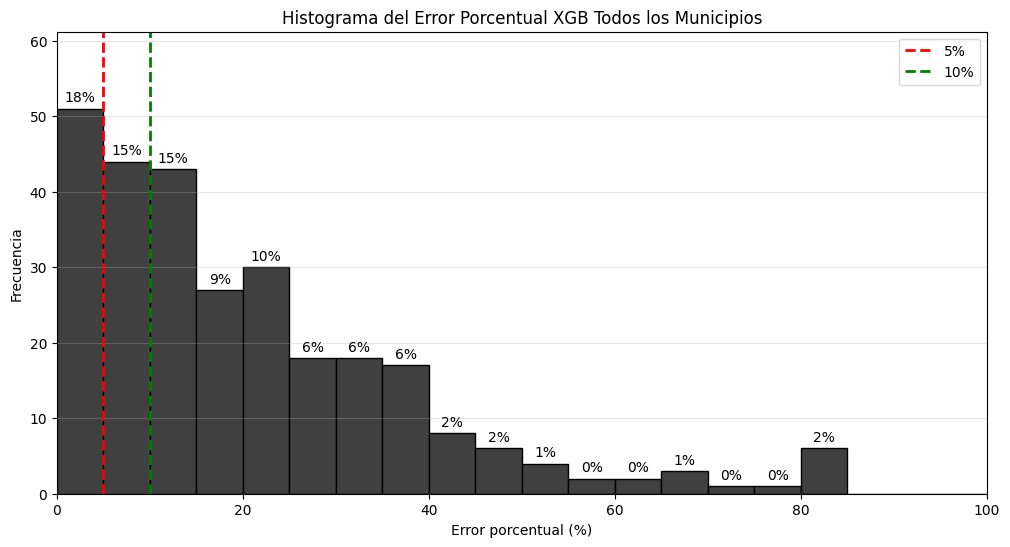

In [73]:
plt.figure(figsize=(12, 6))

# Rango de zoom

zoom_range = results_model_xgb["Error %"].clip(lower=0, upper=80)

# Bins de 5%

bins = np.arange(0, 105, 5)

# Histograma

counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue

total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_ch`

In [74]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_ch):
    X_test_ch_dense = X_test_prep_ch.toarray()
else:
    X_test_ch_dense = X_test_prep_ch

X_test_ch_df = pd.DataFrame(X_test_ch_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_ch_reset = y_test_ch.reset_index(drop=True)

# Filas originales del test
test_rows_ch = data_ch.loc[test_indices_ch].reset_index(drop=True)

# Evaluación
results_model_xgb_ch = evaluation_table(
    lgbm_ch,
    X_test_ch_df,
    y_test_ch_reset,
    test_rows_ch,
    extra_cols
)

results_model_xgb_ch.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","516,245.06","278,245.06",116.91,https://www.casasymas.com.uy/propiedad/113804-...
1,"320,000.00","670,075.64","350,075.64",109.40,https://www.casasymas.com.uy/propiedad/211034-...
2,"1,620,000.00","538,744.56","1,081,255.44",66.74,https://www.casasymas.com.uy/propiedad/48875-c...
3,"1,500,000.00","674,704.77","825,295.23",55.02,https://www.casasymas.com.uy/propiedad/170824-...
4,"245,000.00","373,888.72","128,888.72",52.61,https://www.casasymas.com.uy/propiedad/192057-...
5,"785,000.00","391,582.01","393,417.99",50.12,https://www.casasymas.com.uy/propiedad/184718-...
6,"540,000.00","768,959.83","228,959.83",42.40,https://www.casasymas.com.uy/propiedad/195610-...
7,"185,000.00","259,048.18","74,048.18",40.03,https://www.casasymas.com.uy/propiedad/167907-...
8,"1,350,000.00","833,387.06","516,612.94",38.27,https://www.casasymas.com.uy/propiedad/182809-...
9,"495,000.00","311,415.32","183,584.68",37.09,https://www.casasymas.com.uy/propiedad/167515-...


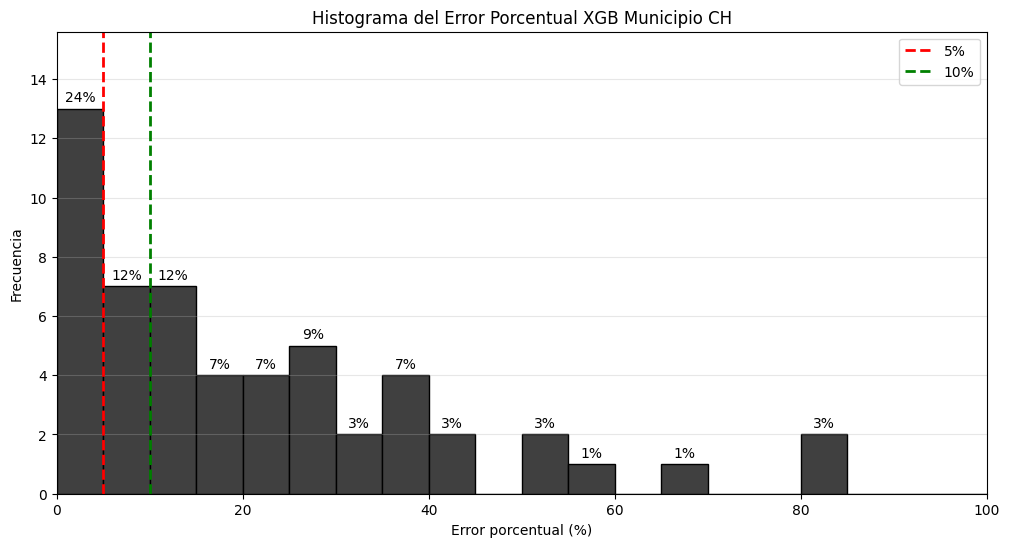

In [75]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_e`

In [76]:
results_model_xgb_e = evaluation_table(
    xgb_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_xgb_e.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","650,307.44","470,307.44",261.28,https://www.casasymas.com.uy/propiedad/169029-...
1,"360,000.00","642,323.00","282,323.00",78.42,https://www.casasymas.com.uy/propiedad/191076-...
2,"375,000.00","631,602.88","256,602.87",68.43,https://www.casasymas.com.uy/propiedad/208201-...
3,"199,000.00","313,078.16","114,078.16",57.33,https://www.casasymas.com.uy/propiedad/194469-...
4,"850,000.00","1,298,478.88","448,478.88",52.76,https://www.casasymas.com.uy/propiedad/95141-c...
5,"360,000.00","534,824.75","174,824.75",48.56,https://www.casasymas.com.uy/propiedad/119722-...
6,"360,000.00","534,824.75","174,824.75",48.56,https://www.casasymas.com.uy/propiedad/203735-...
7,"135,000.00","200,504.58","65,504.58",48.52,https://www.casasymas.com.uy/propiedad/188669-...
8,"480,000.00","710,870.19","230,870.19",48.10,https://www.casasymas.com.uy/propiedad/131012-...
9,"280,000.00","413,102.78","133,102.78",47.54,https://www.casasymas.com.uy/propiedad/221704-...


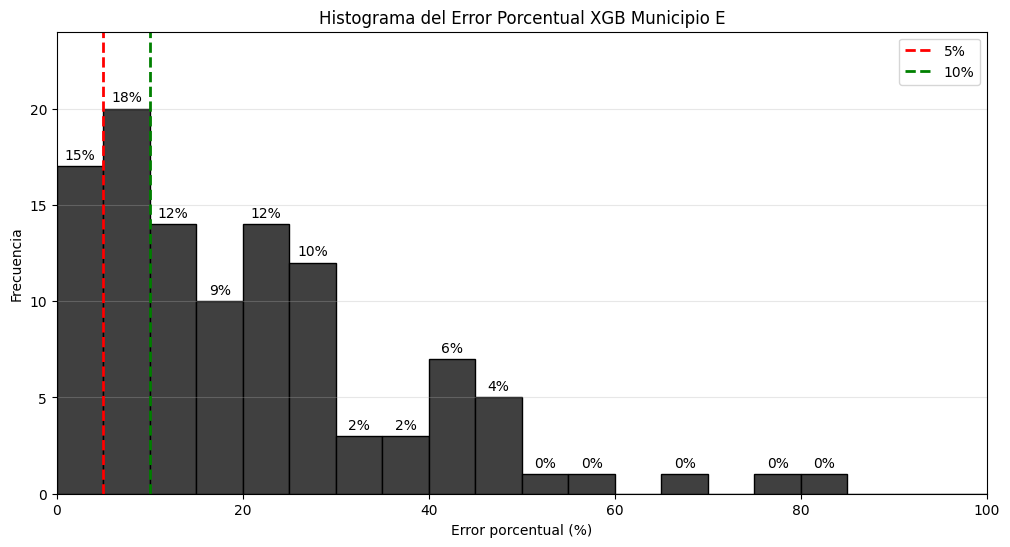

In [77]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lgbm`

In [78]:
results_model_lgbm = evaluation_table(
    model_lgbm,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_lgbm.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","338,492.54","200,592.54",145.46,https://www.casasymas.com.uy/propiedad/205556-...
1,"170,000.00","407,102.61","237,102.61",139.47,https://www.casasymas.com.uy/propiedad/206522-...
2,"129,000.00","249,171.04","120,171.04",93.16,https://www.casasymas.com.uy/propiedad/159112-...
3,"360,000.00","691,592.32","331,592.32",92.11,https://www.casasymas.com.uy/propiedad/191076-...
4,"439,000.00","813,348.94","374,348.94",85.27,https://www.casasymas.com.uy/propiedad/74195-c...
5,"238,000.00","440,635.10","202,635.10",85.14,https://www.casasymas.com.uy/propiedad/113804-...
6,"43,000.00","79,588.35","36,588.35",85.09,https://www.casasymas.com.uy/propiedad/203258-...
7,"45,000.00","82,387.08","37,387.08",83.08,https://www.casasymas.com.uy/propiedad/151994-...
8,"439,000.00","790,100.58","351,100.58",79.98,https://www.casasymas.com.uy/propiedad/74195-c...
9,"65,000.00","115,322.82","50,322.82",77.42,https://www.casasymas.com.uy/propiedad/188981-...


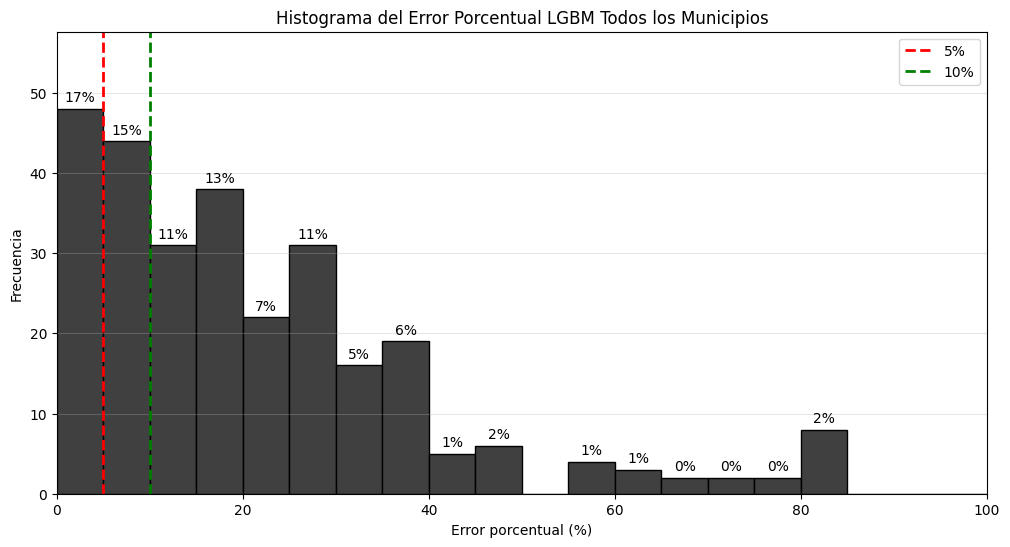

In [79]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_ch`

In [80]:
results_model_lgbm_ch = evaluation_table(
    lgbm_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_lgbm_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","516,245.06","278,245.06",116.91,https://www.casasymas.com.uy/propiedad/113804-...
1,"320,000.00","670,075.64","350,075.64",109.40,https://www.casasymas.com.uy/propiedad/211034-...
2,"1,620,000.00","538,744.56","1,081,255.44",66.74,https://www.casasymas.com.uy/propiedad/48875-c...
3,"1,500,000.00","674,704.77","825,295.23",55.02,https://www.casasymas.com.uy/propiedad/170824-...
4,"245,000.00","373,888.72","128,888.72",52.61,https://www.casasymas.com.uy/propiedad/192057-...
5,"785,000.00","391,582.01","393,417.99",50.12,https://www.casasymas.com.uy/propiedad/184718-...
6,"540,000.00","768,959.83","228,959.83",42.40,https://www.casasymas.com.uy/propiedad/195610-...
7,"185,000.00","259,048.18","74,048.18",40.03,https://www.casasymas.com.uy/propiedad/167907-...
8,"1,350,000.00","833,387.06","516,612.94",38.27,https://www.casasymas.com.uy/propiedad/182809-...
9,"495,000.00","311,415.32","183,584.68",37.09,https://www.casasymas.com.uy/propiedad/167515-...


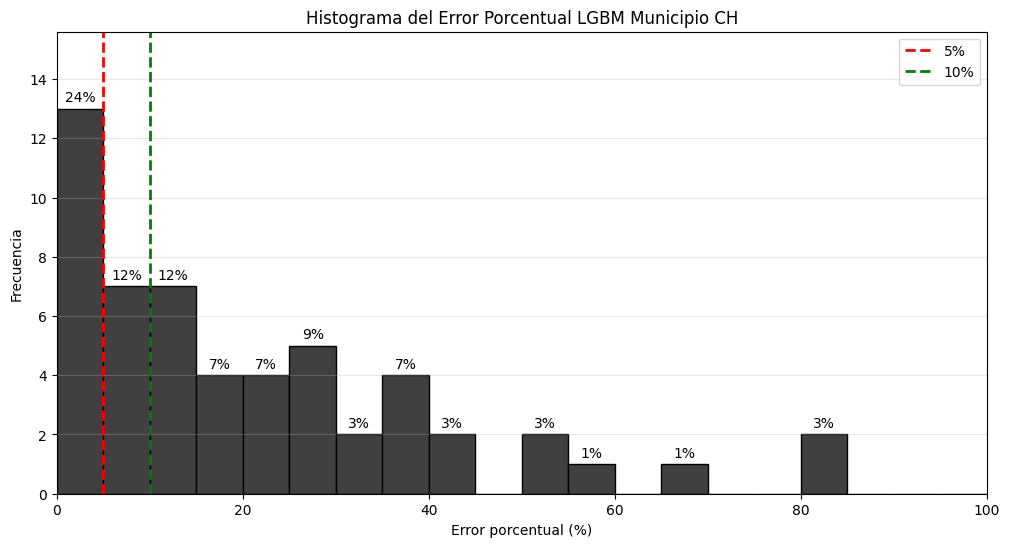

In [81]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_e`

In [82]:
results_model_lgbm_e = evaluation_table(
    lgbm_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_lgbm_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","667,420.16","487,420.16",270.79,https://www.casasymas.com.uy/propiedad/169029-...
1,"360,000.00","664,707.80","304,707.80",84.64,https://www.casasymas.com.uy/propiedad/191076-...
2,"115,000.00","209,254.68","94,254.68",81.96,https://www.casasymas.com.uy/propiedad/224989-...
3,"129,000.00","227,494.28","98,494.28",76.35,https://www.casasymas.com.uy/propiedad/159112-...
4,"395,000.00","676,916.92","281,916.92",71.37,https://www.casasymas.com.uy/propiedad/207514-...
5,"135,000.00","225,392.90","90,392.90",66.96,https://www.casasymas.com.uy/propiedad/188669-...
6,"375,000.00","625,865.96","250,865.96",66.90,https://www.casasymas.com.uy/propiedad/208201-...
7,"480,000.00","799,343.84","319,343.84",66.53,https://www.casasymas.com.uy/propiedad/131012-...
8,"280,000.00","438,235.82","158,235.82",56.51,https://www.casasymas.com.uy/propiedad/221704-...
9,"199,000.00","310,225.27","111,225.27",55.89,https://www.casasymas.com.uy/propiedad/194469-...


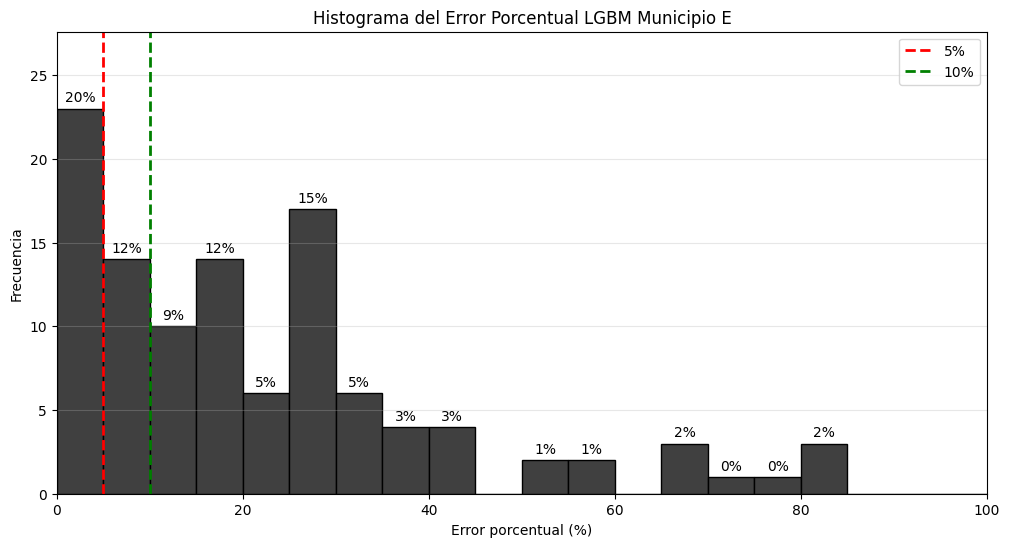

In [83]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr`

In [84]:
results_model_lr = evaluation_table(
    model_lr,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_lr.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","488,290.99","350,390.99",254.09,https://www.casasymas.com.uy/propiedad/205556-...
1,"170,000.00","432,301.56","262,301.56",154.30,https://www.casasymas.com.uy/propiedad/206522-...
2,"440,000.00","877,675.60","437,675.60",99.47,https://www.casasymas.com.uy/propiedad/198708-...
3,"238,000.00","473,299.59","235,299.59",98.87,https://www.casasymas.com.uy/propiedad/113804-...
4,"90,000.00","175,039.11","85,039.11",94.49,https://www.casasymas.com.uy/propiedad/123306-...
5,"360,000.00","632,781.65","272,781.65",75.77,https://www.casasymas.com.uy/propiedad/191076-...
6,"270,000.00","468,824.81","198,824.81",73.64,https://www.casasymas.com.uy/propiedad/129839-...
7,"45,000.00","77,436.44","32,436.44",72.08,https://www.casasymas.com.uy/propiedad/151994-...
8,"200,000.00","334,135.98","134,135.98",67.07,https://www.casasymas.com.uy/propiedad/227205-...
9,"160,000.00","261,915.64","101,915.64",63.70,https://www.casasymas.com.uy/propiedad/204574-...


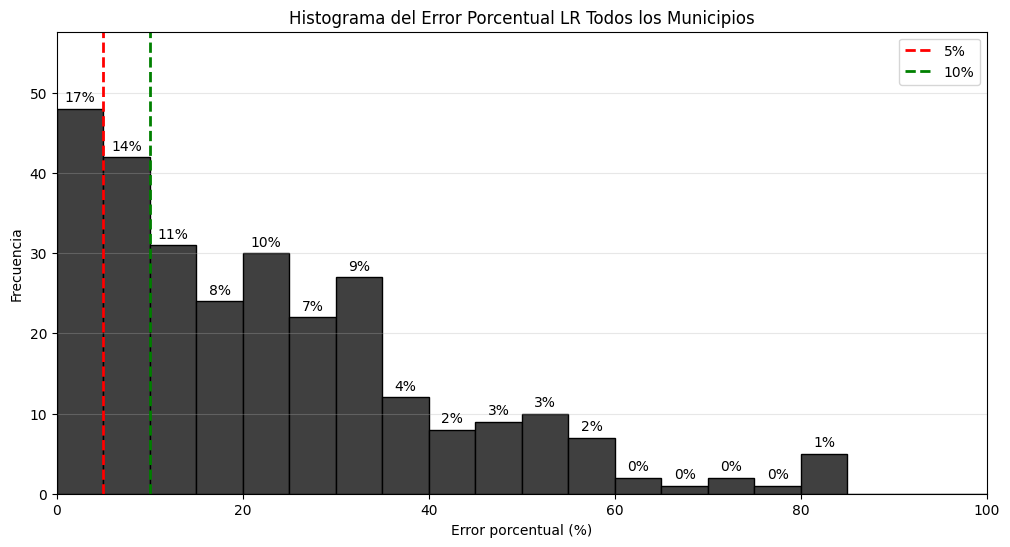

In [85]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_ch`

In [86]:
results_model_lr_ch = evaluation_table(
    model_lr_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_lr_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"320,000.00","595,084.95","275,084.95",85.96,https://www.casasymas.com.uy/propiedad/211034-...
1,"238,000.00","406,517.26","168,517.26",70.81,https://www.casasymas.com.uy/propiedad/113804-...
2,"420,000.00","671,931.87","251,931.87",59.98,https://www.casasymas.com.uy/propiedad/38319-c...
3,"405,000.00","612,600.79","207,600.79",51.26,https://www.casasymas.com.uy/propiedad/221984-...
4,"130,000.00","190,251.63","60,251.63",46.35,https://www.casasymas.com.uy/propiedad/203660-...
5,"1,620,000.00","989,804.61","630,195.39",38.90,https://www.casasymas.com.uy/propiedad/48875-c...
6,"330,000.00","207,306.69","122,693.31",37.18,https://www.casasymas.com.uy/propiedad/200339-...
7,"785,000.00","500,171.77","284,828.23",36.28,https://www.casasymas.com.uy/propiedad/184718-...
8,"240,000.00","153,609.79","86,390.21",36.00,https://www.casasymas.com.uy/propiedad/149759-...
9,"439,000.00","592,947.32","153,947.32",35.07,https://www.casasymas.com.uy/propiedad/74195-c...


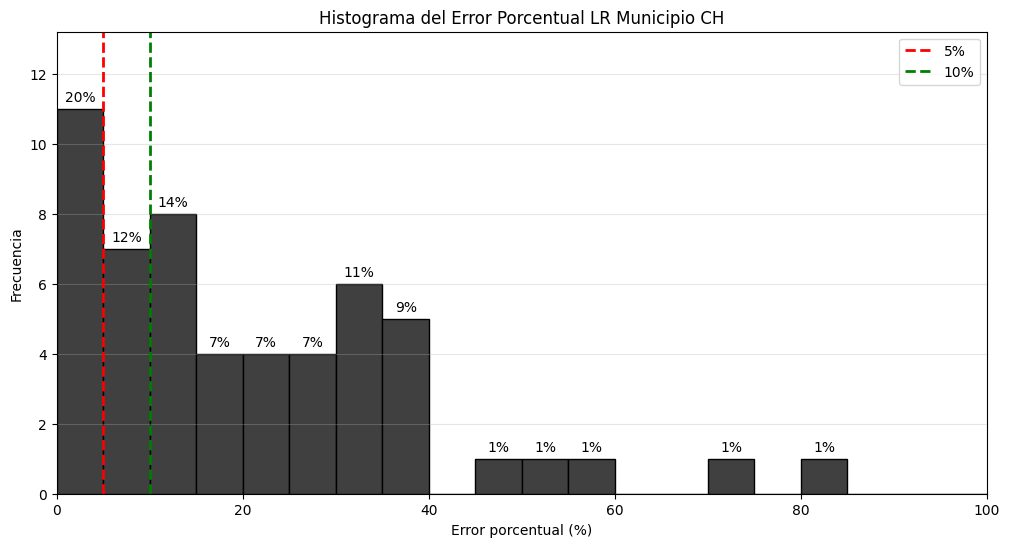

In [87]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_e`

In [88]:
results_model_lr_e = evaluation_table(
    model_lr_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_lr_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","560,372.43","380,372.43",211.32,https://www.casasymas.com.uy/propiedad/169029-...
1,"115,000.00","206,975.19","91,975.19",79.98,https://www.casasymas.com.uy/propiedad/224989-...
2,"360,000.00","628,133.88","268,133.88",74.48,https://www.casasymas.com.uy/propiedad/191076-...
3,"135,000.00","230,571.27","95,571.27",70.79,https://www.casasymas.com.uy/propiedad/188669-...
4,"395,000.00","673,447.19","278,447.19",70.49,https://www.casasymas.com.uy/propiedad/207514-...
5,"280,000.00","463,876.82","183,876.82",65.67,https://www.casasymas.com.uy/propiedad/221704-...
6,"235,000.00","361,600.38","126,600.38",53.87,https://www.casasymas.com.uy/propiedad/202567-...
7,"675,000.00","1,025,102.72","350,102.72",51.87,https://www.casasymas.com.uy/propiedad/158920-...
8,"540,000.00","819,652.10","279,652.10",51.79,https://www.casasymas.com.uy/propiedad/205375-...
9,"199,000.00","289,264.21","90,264.21",45.36,https://www.casasymas.com.uy/propiedad/194469-...


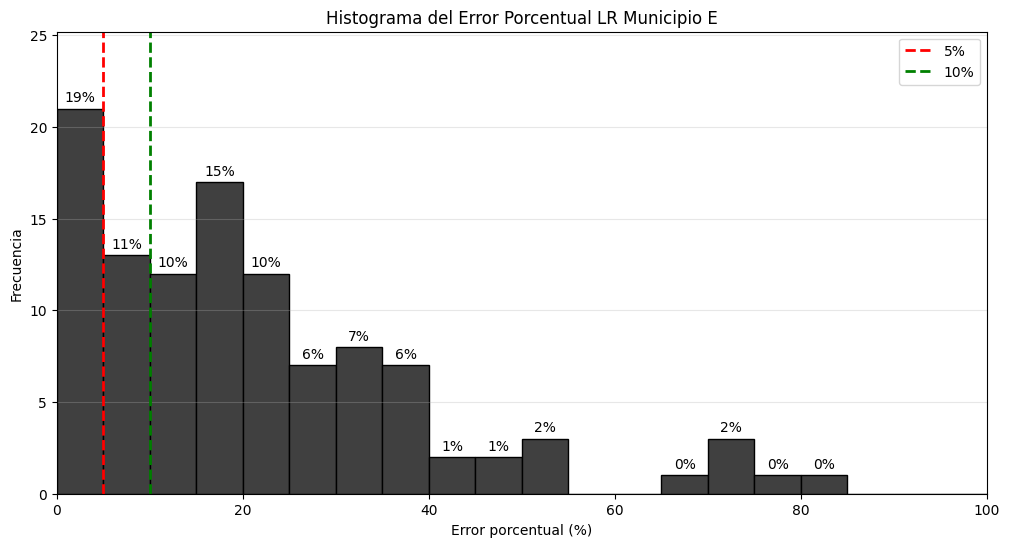

In [89]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_all_municipios`

In [90]:
results_model_rf_all_municipios = evaluation_table(
    rf_all_municipios,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_rf_all_municipios.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","343,023.37","205,123.37",148.75,https://www.casasymas.com.uy/propiedad/205556-...
1,"45,000.00","105,970.88","60,970.88",135.49,https://www.casasymas.com.uy/propiedad/151994-...
2,"170,000.00","369,460.10","199,460.10",117.33,https://www.casasymas.com.uy/propiedad/206522-...
3,"43,000.00","86,819.90","43,819.90",101.91,https://www.casasymas.com.uy/propiedad/203258-...
4,"58,905.00","114,244.03","55,339.03",93.95,https://www.casasymas.com.uy/propiedad/191802-...
5,"238,000.00","450,616.69","212,616.69",89.33,https://www.casasymas.com.uy/propiedad/113804-...
6,"90,000.00","169,294.79","79,294.79",88.11,https://www.casasymas.com.uy/propiedad/123306-...
7,"65,000.00","116,101.04","51,101.04",78.62,https://www.casasymas.com.uy/propiedad/188981-...
8,"360,000.00","628,616.84","268,616.84",74.62,https://www.casasymas.com.uy/propiedad/191076-...
9,"75,000.00","129,614.16","54,614.16",72.82,https://www.casasymas.com.uy/propiedad/90139-c...


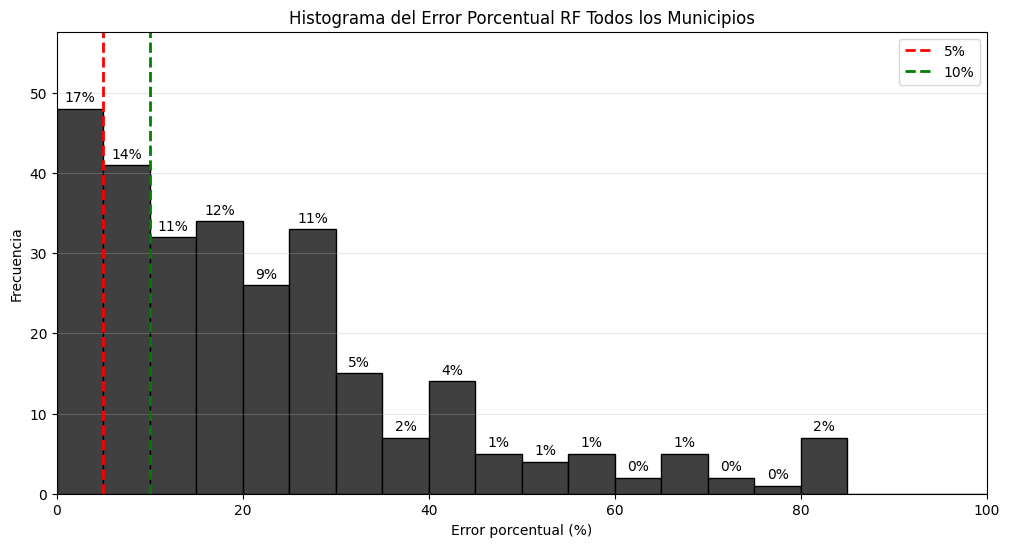

In [91]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_all_municipios["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipios_ch`

In [92]:
results_model_rf_municipio_ch = evaluation_table(
    rf_municipio_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_rf_municipio_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"238,000.00","512,305.62","274,305.62",115.25,https://www.casasymas.com.uy/propiedad/113804-...
1,"320,000.00","569,693.49","249,693.49",78.03,https://www.casasymas.com.uy/propiedad/211034-...
2,"1,620,000.00","612,918.82","1,007,081.18",62.17,https://www.casasymas.com.uy/propiedad/48875-c...
3,"1,500,000.00","737,600.28","762,399.72",50.83,https://www.casasymas.com.uy/propiedad/170824-...
4,"1,350,000.00","682,671.00","667,329.00",49.43,https://www.casasymas.com.uy/propiedad/182809-...
5,"439,000.00","633,288.98","194,288.98",44.26,https://www.casasymas.com.uy/propiedad/74195-c...
6,"179,000.00","256,405.80","77,405.80",43.24,https://www.casasymas.com.uy/propiedad/199371-...
7,"785,000.00","471,560.37","313,439.63",39.93,https://www.casasymas.com.uy/propiedad/184718-...
8,"1,090,000.00","664,105.44","425,894.56",39.07,https://www.casasymas.com.uy/propiedad/111111-...
9,"185,000.00","256,932.96","71,932.96",38.88,https://www.casasymas.com.uy/propiedad/167907-...


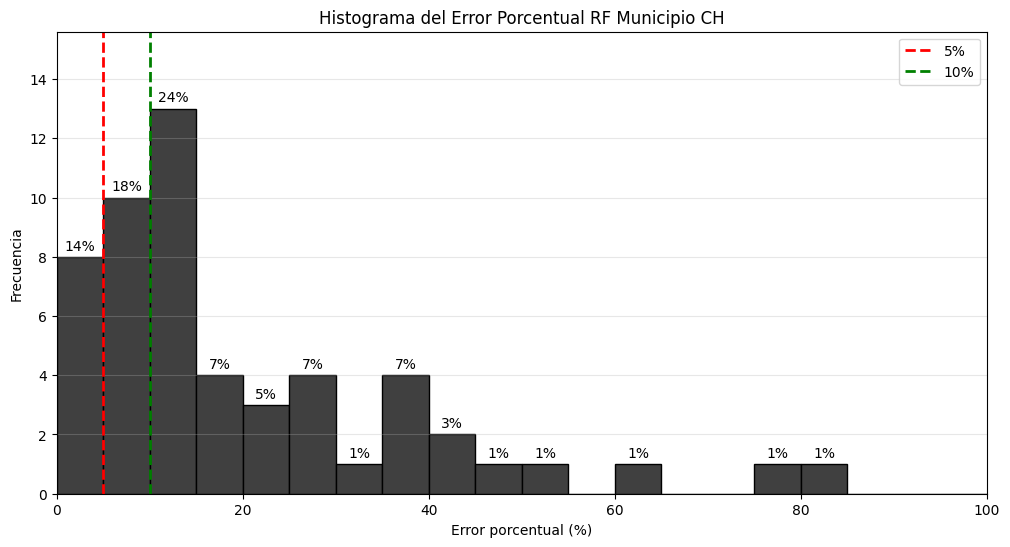

In [93]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipio_e`

In [94]:
results_model_rf_municipio_e = evaluation_table(
    rf_municipio_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_rf_municipio_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"180,000.00","612,121.43","432,121.43",240.07,https://www.casasymas.com.uy/propiedad/169029-...
1,"135,000.00","259,499.51","124,499.51",92.22,https://www.casasymas.com.uy/propiedad/188669-...
2,"360,000.00","657,021.83","297,021.83",82.51,https://www.casasymas.com.uy/propiedad/191076-...
3,"115,000.00","208,792.46","93,792.46",81.56,https://www.casasymas.com.uy/propiedad/224989-...
4,"395,000.00","672,584.50","277,584.50",70.27,https://www.casasymas.com.uy/propiedad/207514-...
5,"129,000.00","208,272.54","79,272.54",61.45,https://www.casasymas.com.uy/propiedad/159112-...
6,"199,000.00","312,776.21","113,776.21",57.17,https://www.casasymas.com.uy/propiedad/194469-...
7,"375,000.00","573,688.25","198,688.25",52.98,https://www.casasymas.com.uy/propiedad/208201-...
8,"280,000.00","427,331.87","147,331.87",52.62,https://www.casasymas.com.uy/propiedad/221704-...
9,"480,000.00","711,381.48","231,381.48",48.20,https://www.casasymas.com.uy/propiedad/131012-...


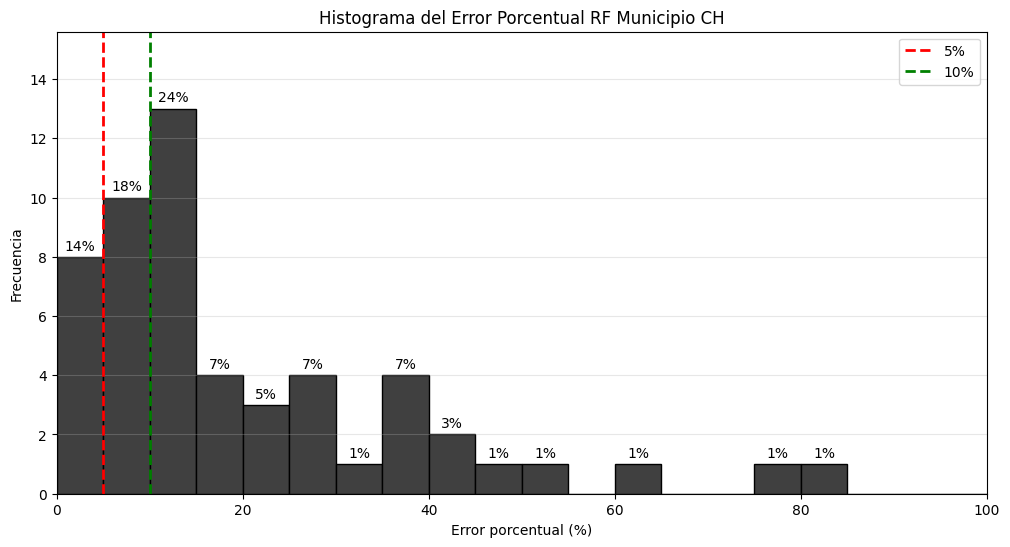

In [95]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()